In [1]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
from gemsrs_utils import *

np.random.seed(1)  # We don't use it, but if we do, set it for determinism


In [2]:
# Open file
# events = uproot.open("003200_v9_hists.root")["events"]
events = uproot.open("D:\\data\\gemtrd\\003200_v10_hists.root")["events"]
# events.keys() # <== Uncomment to see tree branch names

In [3]:
# Based on events tree, read constants: 
num_time_bins = get_num_time_bins(events)
num_apvs = get_num_apvs(events, num_time_bins)
ch_mapping = get_channel_order(events, num_apvs)
# Channels bar centers that are used in various plots
ch_bar_centers = np.arange(num_channels) - 0.5

print(f"Number of time bins: {num_time_bins}, Number of APVs: {num_apvs}")
print(f"Check mapping: {np.shape(ch_mapping)}")
# print(ch_mapping)   # <== Uncomment to see channels order

Number of time bins: 6, Number of APVs: 7
Check mapping: (128,)


In [4]:
entry_start = 2                     # 1st event to process
entry_stop = entry_start + 1000     # Last event to process

unsorted_raw_samples =  events['srs_raw_samples'].array(
    library="np", entry_start=entry_start, entry_stop=entry_stop)


## Explanation of data: 
We have data in *srs_raw_samples* that looks like this (**num_time_bins=3**)
```
[
  [2820, 2810, 2717, 2774,  ...],  # event 0
  [2886, 2814, 2757, 2833,  ...],  # event 1
  ...
]
```
The values correspond to apv:channel:time-bin
Imagine we have 3 time bins, then the previous data for a single event (1 row) will correspond to

```
[apv0:ch0:t0, apv0:ch0:t1, apv0:ch0:t2, apv0:ch1:t0 ... apv0:ch128:t2, apv1:ch0:t0, ...]
```

In [5]:
# Convert co (events, apvs, channels, time-bins) shape
reshape_tuple = (len(unsorted_raw_samples), num_apvs, num_channels, num_time_bins)
print(f"Reshaping {np.shape(np.vstack(unsorted_raw_samples))} to {reshape_tuple}")
channel_data = np.vstack(unsorted_raw_samples).reshape(reshape_tuple)
print(channel_data.shape)

# channel_data is of shape (1000, 7, 128, 6), the ch_mapping is (128) w
# We will sort along the third axis using the indices from ch_mapping
raw_samples = np.take_along_axis(channel_data, ch_mapping[np.newaxis, np.newaxis, :, np.newaxis], axis=2)

Reshaping (1000, 5376) to (1000, 7, 128, 6)
(1000, 7, 128, 6)


In [6]:
# Compute the mean over the 0-th and 3-rd axes
pedestals = np.mean(raw_samples, axis=(0, 3))
# pedestals     # <= uncomment to look exact values

In [7]:
# Subtract pedestals
samples = raw_samples - pedestals[np.newaxis, :, :, np.newaxis]
# samples[0][0]

In [8]:
noises = np.std(samples, axis=(0, 3))
noises.shape

(7, 128)

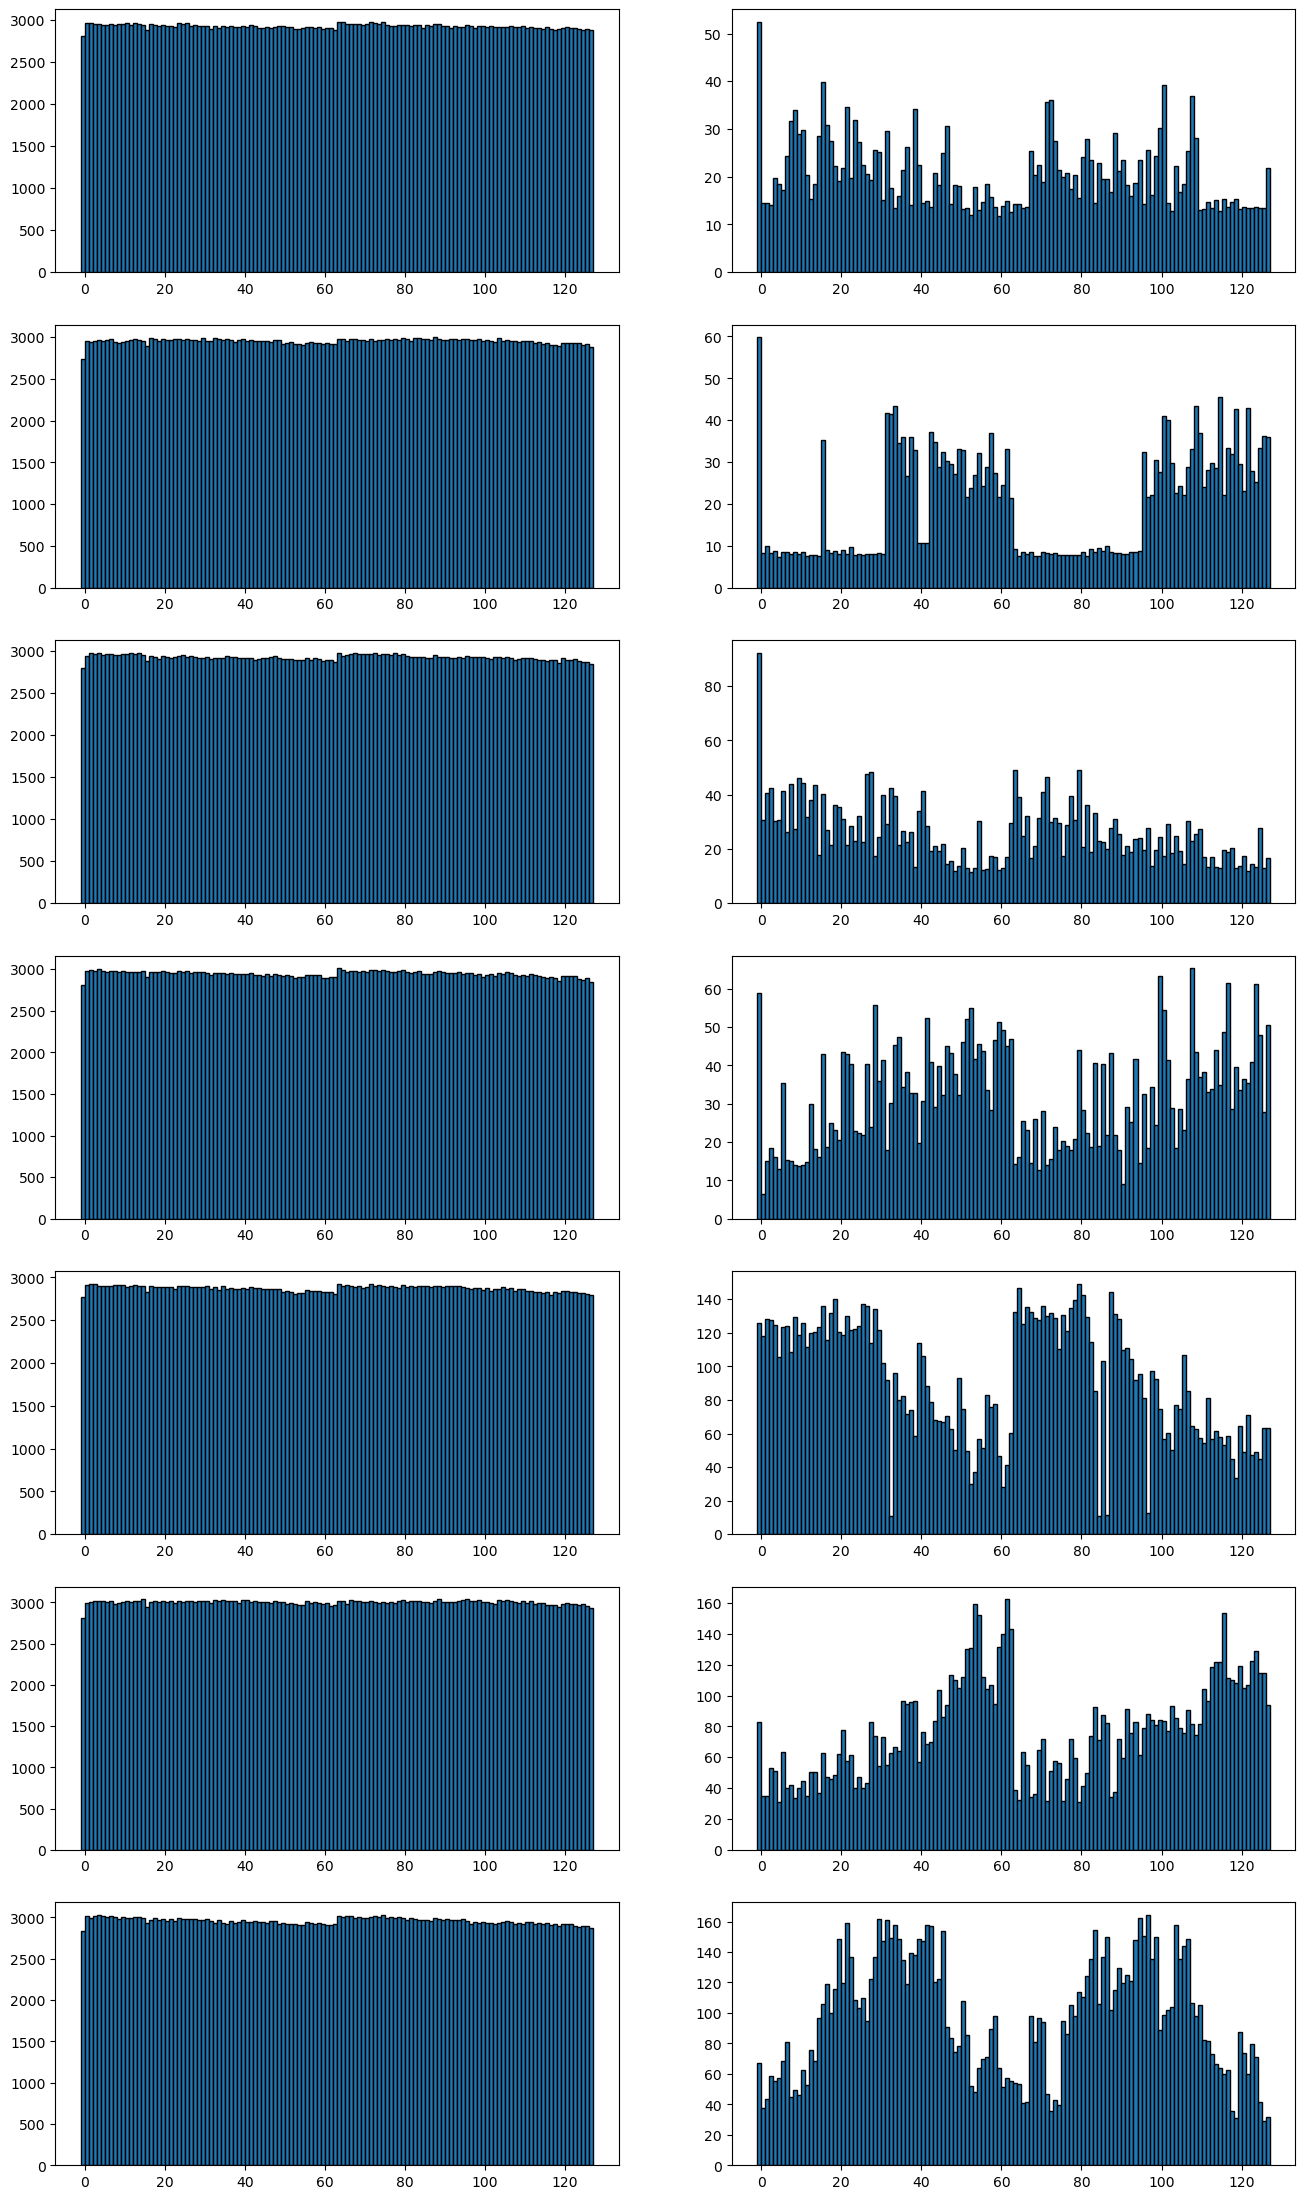

In [9]:
# Generate x values

# Create the figure and axes objects
_, apv_axes = plt.subplots(num_apvs, 2, figsize=(16, 4*num_apvs))  # You can specify your figure size here

for i_apv, axes in enumerate(apv_axes):
    # print(axes, ch_bar_centers.shape, pedestals[i_apv].shape, noises[i_apv].shape)
    axes[0].bar(ch_bar_centers, pedestals[i_apv], width=1.0, edgecolor='black')
    axes[1].bar(ch_bar_centers, noises[i_apv], width=1.0, edgecolor='black')
    
#     ax.bar(ch_bar_centers, pedestals[i], width=1)
# 
# # Create the figure and axes objects
# _, ax = plt.subplots(figsize=(16, 6))  # You can specify your figure size here
# 
# # Create the bar plot on the axes object
# ax.bar(x_values, pedestals[0], width=1.0, edgecolor='black')
# 
# # Set axis titles
# ax.set_xlabel('Channels')
# ax.set_ylabel('Pedestals')



In [10]:

# Reshape mean_array for broadcasting
mean_array_reshaped = pedestals[:, :, np.newaxis]

# Subtract mean_array from every element in array across the 0-th and 3-rd axes
array_centered = -1*(channel_data - mean_array_reshaped)

# Verify the operation
array_centered.shape

(1000, 7, 128, 6)

In [11]:
#np.transpose(array_centered, (0,1,3,2)).reshape(len(array_centered),num_apvs, num_channels*num_time_bins)
flattened = np.transpose(channel_data, (0,1,3,2)).reshape(len(array_centered),num_apvs, num_channels*num_time_bins)
flattened.shape

(1000, 7, 768)

ValueError: shape mismatch: objects cannot be broadcast to a single shape

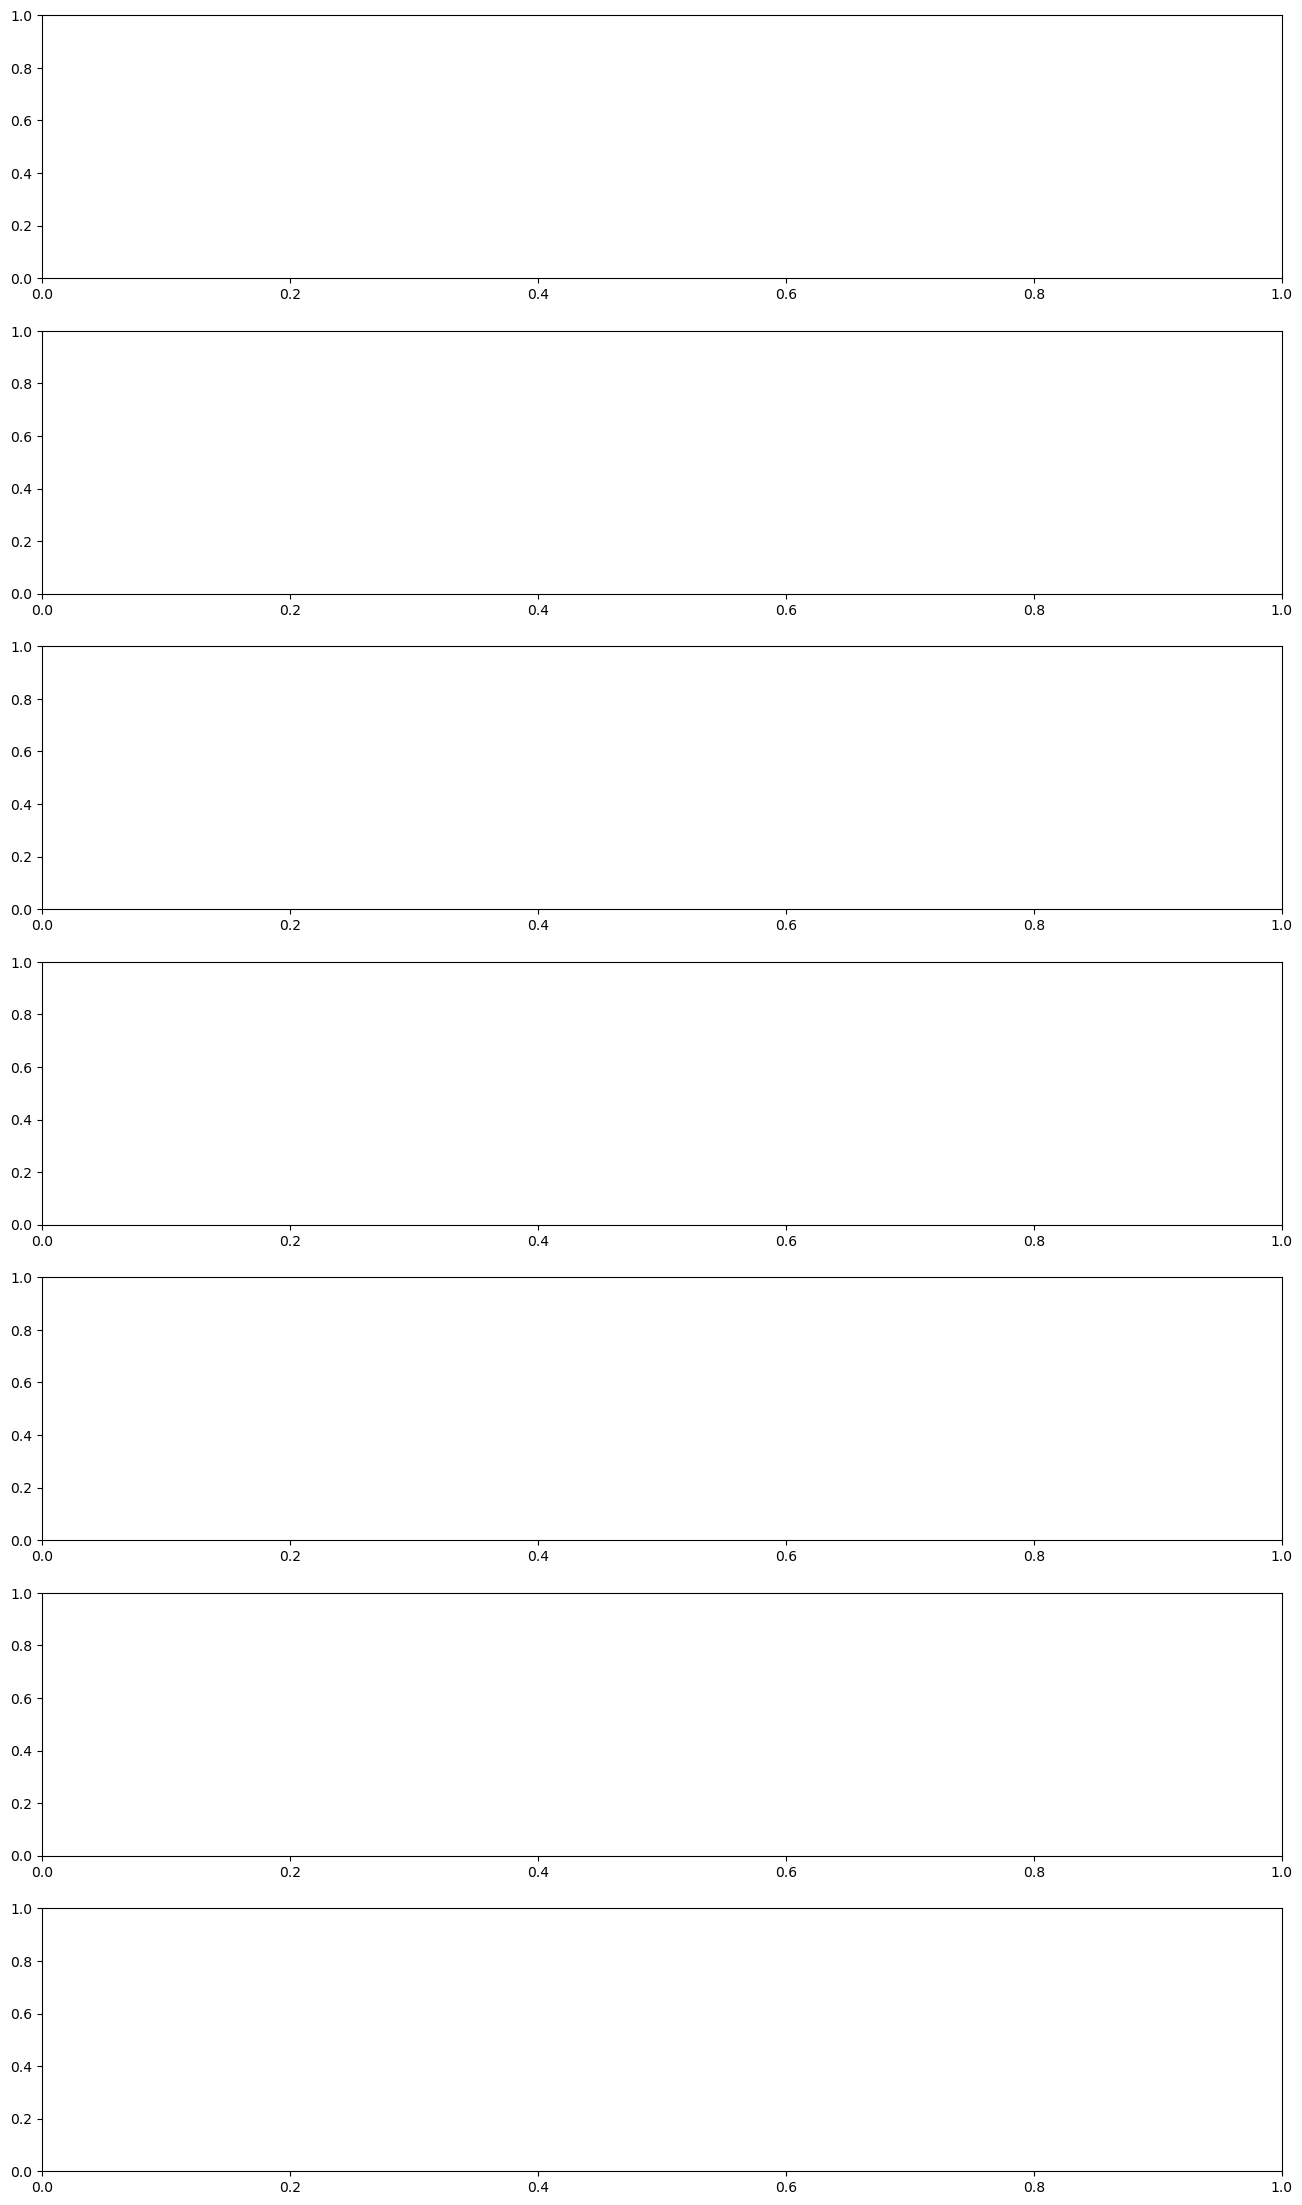

In [12]:

# Create the figure and axes objects
_, axes = plt.subplots(num_apvs, 1, figsize=(16, 4*num_apvs))  # You can specify your figure size here

for i,ax in enumerate(axes.flat):
    ax.bar(ch_bar_centers, flattened[5][i], width=1)
    # Create the bar plot on the axes object
    #ax.bar(x_values, flattened[4][2], width=1)
    
    # Set axis titles
    #ax.set_xlabel('Channels')
    #ax.set_ylabel('Pedestals')

#plt.bar(np.arange(128) - 0.5, pedestals[0])#, where='post')

In [ ]:
# channel_data is of shape (1000, 7, 128, 6), the ch_mapping is (128) w
# We will sort along the third axis using the indices from ch_mapping
raw_samples = np.take_along_axis(channel_data, ch_mapping[np.newaxis, np.newaxis, :, np.newaxis], axis=2)

# Verify the shape of the sorted array
raw_samples.shape

In [ ]:
full_apv = (np.transpose(raw_samples, (0, 1, 3, 2))
            .reshape(len(raw_samples), num_apvs, num_channels * num_time_bins))
full_apv.shape

In [ ]:
x_values = np.arange(num_channels*num_time_bins) - 0.5

# Create the figure and axes objects
fig, axes = plt.subplots(num_apvs, 1, figsize=(16, 4*num_apvs))  # You can specify your figure size here
for i,ax in enumerate(axes.flat):
    ax.bar(x_values, full_apv[500][i], width=1)

In [ ]:
# Creating a 3D array for demonstration
array = np.array([[[1, 2, 3], [4,5,6]], [[7,8, 9], [10,11,12]]])

# Transpose the array over the second and third axes
transposed_array = np.transpose(array, (0, 2, 1))

# Reshape each 2x2 sub-array into a 1D array
result_array = transposed_array.reshape(transposed_array.shape[0], -1)

result_array